## SQL Statement to Extract Results
```sql
    SELECT `openmlid`, `seed`, `target_type`, `analysis` FROM `asforests_analysis_classification`
    INTO OUTFILE 'results_classification_sensitivity.csv' 
    FIELDS ENCLOSED BY '' 
    TERMINATED BY ';' 
    ESCAPED BY '"' 
    LINES TERMINATED BY '\r\n';
```

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
from py_experimenter import utils
datasets_classification = [int(i) for i in utils.get_keyfield_data(utils.load_config(f"config/experiments-fullforests-classification.cfg"))["openmlid"]]
datasets_regression = [int(i) for i in utils.get_keyfield_data(utils.load_config(f"config/experiments-fullforests-regression.cfg"))["openmlid"]]

In [3]:
import os

def write_sensitivity_results(df_results_bare):
    
    df_results = df_results_bare[df_results_bare["status"] == "done"]
    
    datasets = []
    Z_oob = []
    Z_val = []
    for openmlid, df_dataset in tqdm(df_results.groupby("openmlid")):
        rows_dataset = []
        z_oob = np.zeros(10)
        z_val = np.zeros(10)
        for i, row in df_dataset.iterrows():
            try:
                rows_case = []
                for entry in json.loads(row["analysis"]):
                    del entry[-2] # eliminate the gap, that is computed later anyway
                    rows_case.append([row["openmlid"], row["seed"], row["target_type"]] + entry)
                if row["target_type"] == "oob":
                    z_oob[row["seed"]] += len(rows_case)
                elif row["target_type"] == "val":
                    z_val[row["seed"]] += len(rows_case)
                else:
                    raise Exception()
                rows_dataset.extend(rows_case)
            except KeyboardInterrupt:
                raise
            except:
                print(f"error, skipping on {openmlid}")
                pass
            
        Z_oob.append(list(z_oob))
        Z_val.append(list(z_val))
        pd.DataFrame(rows_dataset, columns=["openmlid", "seed", "target_type", "epsilon", "w_min", "delta", "c", "bootstrap_repeats", "num_trees", "reasoning_time_per_tree_in_ns"]).to_csv(f"sensitivity/{openmlid}.csv", index=False)
        datasets.append(openmlid)
    return datasets, np.array(Z_oob), np.array(Z_val)
    
    
def plot_result_availability(datasets, availability_oob, availability_val):
    fig, axs = plt.subplots(1, 2, figsize=(8,0.4 * len(datasets)))
    for ax, availability in zip(axs, [availability_oob, availability_val]):
        ax.imshow(-availability, cmap="coolwarm", vmin = -34020, vmax = 0)
        ax.set_yticks(range(len(datasets)))
        ax.set_yticklabels(datasets)
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-.5, len(datasets), 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    fig.tight_layout()
    plt.show()
    
def process_all_sensitivity_results_from_file(filename, chunksize = 100):
    
    # determine which rows in the file belong to which dataset
    file1 = open(filename, 'r')
    dataset_col = []
    while True:
        line = file1.readline()
        try:
            if not line:
                break
            parts = line.split(";")
            dataset_col.append(int(parts[0][1:-1]))
        except KeyboardInterrupt:
            raise
        except:
            pass
    file1.close()
    df_indices = pd.DataFrame(np.array([dataset_col]).T, columns=["openmlid"])
    
    # find datasets for which no file exists yet
    
    datasets = [i for i in pd.unique(df_indices["openmlid"]) if not os.path.exists(f"sensitivity/{i}.csv")]
    print(f"Found data for {len(pd.unique(df_indices['openmlid']))} datasets. For {len(datasets)} of them, no CSV file exists. Now creating sensitivity analysis results for these.")
    
    todo = datasets.copy()
    while todo:
        batch = todo[:chunksize]
        indices = set(df_indices[df_indices["openmlid"].isin(batch)].index)
        print(f"Getting rows of {len(indices)} indices: {indices}")
        df_ds = pd.read_csv(filename, sep=";", skiprows=lambda x: x > 0 and not (x - 1) in indices)
        df_ds["status"] = "done"
        print("Read in chunk. Now processing results.")
        plot_result_availability(*write_sensitivity_results(df_ds))
        todo = todo[len(batch):]

Found data for 221 datasets. For 218 of them, no CSV file exists. Now creating sensitivity analysis results for these.
Getting rows of 800 indices: {2443, 2444, 2445, 2446, 2447, 2448, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 

  0%|          | 0/40 [00:00<?, ?it/s]

error, skipping on 16
error, skipping on 18
error, skipping on 18
error, skipping on 21
error, skipping on 21
error, skipping on 21
error, skipping on 22
error, skipping on 22
error, skipping on 23
error, skipping on 23
error, skipping on 23
error, skipping on 26
error, skipping on 28
error, skipping on 30
error, skipping on 30
error, skipping on 32
error, skipping on 33
error, skipping on 36
error, skipping on 36
error, skipping on 36
error, skipping on 44
error, skipping on 44
error, skipping on 46
error, skipping on 54
error, skipping on 54
error, skipping on 54
error, skipping on 57
error, skipping on 61
error, skipping on 61
error, skipping on 61
error, skipping on 154
error, skipping on 154
error, skipping on 180
error, skipping on 181
error, skipping on 181
error, skipping on 181
error, skipping on 182
error, skipping on 182
error, skipping on 182
error, skipping on 185
error, skipping on 188
error, skipping on 273
error, skipping on 273
error, skipping on 273
error, skipping on

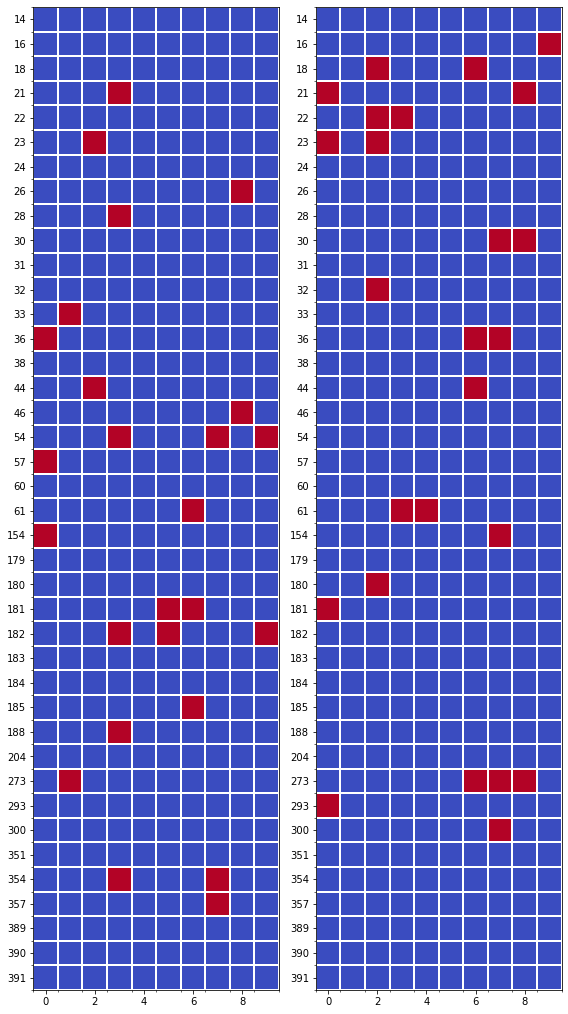

Getting rows of 800 indices: {2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 6

  0%|          | 0/40 [00:00<?, ?it/s]

error, skipping on 392
error, skipping on 392
error, skipping on 392
error, skipping on 395
error, skipping on 396
error, skipping on 396
error, skipping on 401
error, skipping on 401
error, skipping on 485
error, skipping on 485
error, skipping on 485
error, skipping on 679
error, skipping on 679
error, skipping on 715
error, skipping on 720
error, skipping on 722
error, skipping on 723
error, skipping on 727
error, skipping on 728
error, skipping on 735
error, skipping on 735
error, skipping on 735
error, skipping on 737
error, skipping on 737
error, skipping on 737
error, skipping on 741
error, skipping on 741
error, skipping on 743
error, skipping on 743
error, skipping on 743
error, skipping on 752
error, skipping on 752
error, skipping on 799
error, skipping on 799
error, skipping on 803
error, skipping on 806
error, skipping on 807
error, skipping on 813
error, skipping on 813
error, skipping on 821
error, skipping on 822
error, skipping on 823
error, skipping on 833
error, skip

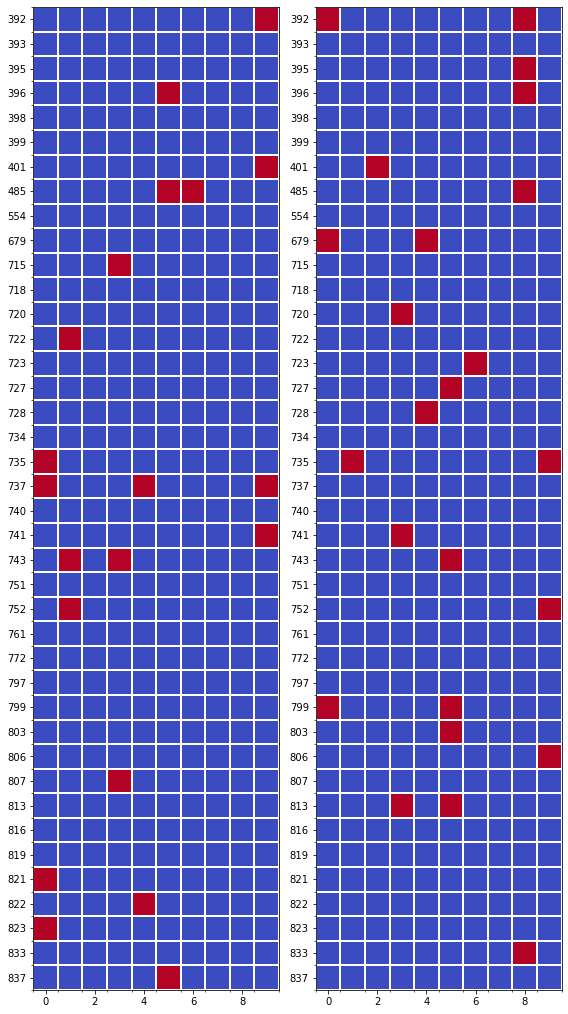

Getting rows of 800 indices: {3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3045, 3270, 3422, 3271, 3272, 3275, 3280, 3285, 3290, 3426, 3046, 3295, 3296, 3300, 3305, 3310, 3315, 3431, 3047, 3321, 3322, 3326, 3331, 3336, 3341, 3436, 3048, 3346, 3347, 3351, 3354, 3356, 3361, 3366, 3049, 3371, 3372, 3376, 3052, 3381, 3386, 3391, 3050, 3396, 3040, 3397, 3401, 3041, 3406, 3042, 3411, 3043, 3416, 3044, 3051, 3421, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 9

  0%|          | 0/40 [00:00<?, ?it/s]

error, skipping on 843
error, skipping on 846
error, skipping on 846
error, skipping on 847
error, skipping on 849
error, skipping on 849
error, skipping on 866
error, skipping on 866
error, skipping on 871
error, skipping on 871
error, skipping on 897
error, skipping on 903
error, skipping on 904
error, skipping on 904
error, skipping on 910
error, skipping on 910
error, skipping on 912
error, skipping on 913
error, skipping on 913
error, skipping on 914
error, skipping on 914
error, skipping on 914
error, skipping on 914
error, skipping on 917
error, skipping on 917
error, skipping on 917
error, skipping on 930
error, skipping on 930
error, skipping on 953
error, skipping on 959
error, skipping on 959
error, skipping on 962
error, skipping on 971
error, skipping on 977
error, skipping on 979
error, skipping on 980
error, skipping on 993
error, skipping on 1000
error, skipping on 1018
error, skipping on 1019
error, skipping on 1019
error, skipping on 1019
error, skipping on 1020


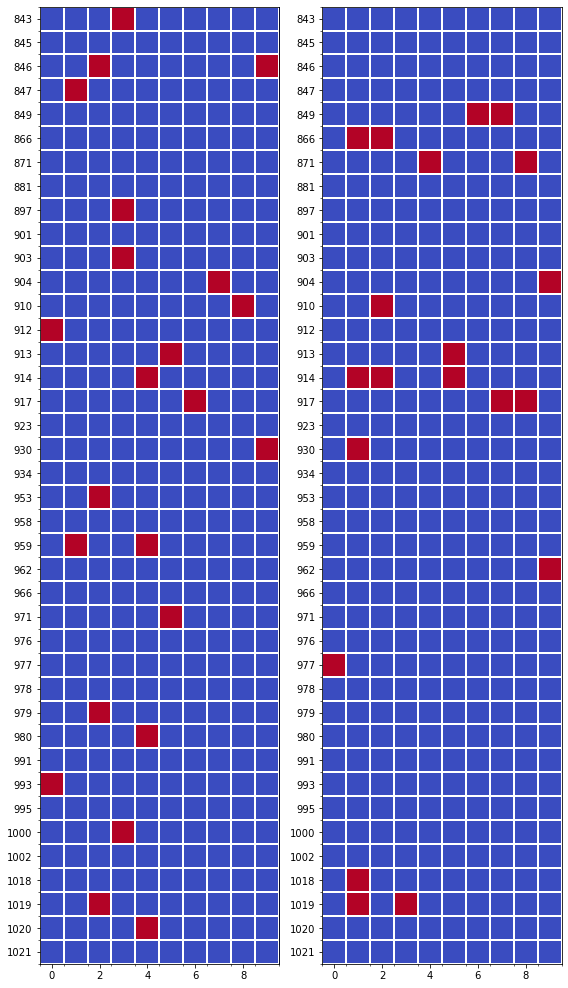

Getting rows of 800 indices: {3664, 3665, 3666, 3501, 3559, 3667, 3668, 3669, 3670, 3671, 3502, 3672, 3503, 3677, 3550, 3504, 3682, 3505, 3688, 3689, 3506, 3693, 3507, 3698, 3508, 3561, 3703, 3551, 3509, 3708, 3510, 3713, 3714, 3511, 3718, 3512, 3723, 3513, 3728, 3514, 3733, 3552, 3515, 3738, 3739, 3516, 3743, 3517, 3748, 3518, 3753, 3519, 3758, 3553, 3520, 3763, 3764, 3521, 3768, 3771, 3522, 3773, 3523, 3778, 3524, 3783, 3554, 3525, 3788, 3789, 3560, 3526, 3793, 3527, 3798, 3528, 3803, 3529, 3808, 3555, 3530, 3813, 3814, 3531, 3818, 3532, 3823, 3533, 3828, 3534, 3833, 3556, 3535, 3838, 3839, 3536, 3537, 3440, 3441, 3442, 3443, 3444, 3538, 3445, 3446, 3447, 3448, 3449, 3539, 3450, 3451, 3557, 3452, 3453, 3454, 3540, 3455, 3456, 3457, 3458, 3459, 3541, 3460, 3461, 3462, 3463, 3464, 3542, 3465, 3466, 3467, 3468, 3469, 3543, 3470, 3471, 3472, 3473, 3474, 3544, 3475, 3476, 3558, 3477, 3478, 3479, 3545, 3480, 3481, 3482, 3483, 3484, 3546, 3485, 3486, 3487, 3488, 3547, 3489, 3490, 3491, 3492

  0%|          | 0/40 [00:00<?, ?it/s]

error, skipping on 1036
error, skipping on 1037
error, skipping on 1041
error, skipping on 1041
error, skipping on 1042
error, skipping on 1049
error, skipping on 1050
error, skipping on 1053
error, skipping on 1059
error, skipping on 1067
error, skipping on 1067
error, skipping on 1068
error, skipping on 1068
error, skipping on 1111
error, skipping on 1111
error, skipping on 1119
error, skipping on 1119
error, skipping on 1120
error, skipping on 1128
error, skipping on 1130
error, skipping on 1130
error, skipping on 1134
error, skipping on 1134
error, skipping on 1138
error, skipping on 1138
error, skipping on 1139
error, skipping on 1146
error, skipping on 1146
error, skipping on 1146
error, skipping on 1242
error, skipping on 1457
error, skipping on 1461
error, skipping on 1464
error, skipping on 1464
error, skipping on 1475
error, skipping on 1485
error, skipping on 1485
error, skipping on 1486
error, skipping on 1487
error, skipping on 1501
error, skipping on 1501
error, skipping 

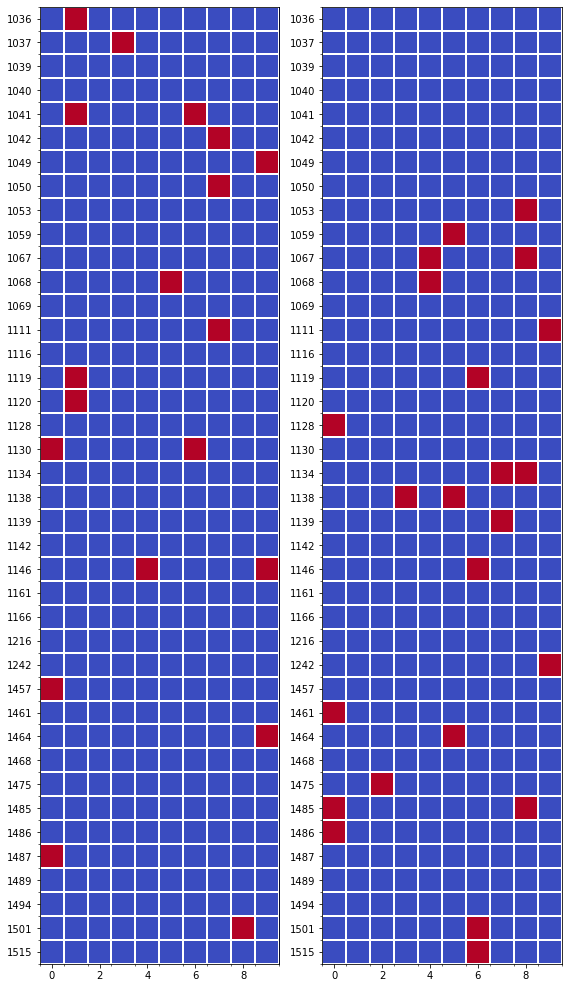

Getting rows of 800 indices: {4096, 4097, 3989, 4071, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4075, 4117, 4118, 4119, 3990, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4080, 4140, 4141, 4142, 3991, 4081, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4085, 4162, 4163, 4164, 3992, 4165, 4166, 4167, 4168, 4169, 4087, 4171, 4172, 4173, 4174, 4088, 4176, 4177, 4178, 4179, 4089, 4181, 4182, 4183, 4184, 4090, 4186, 4187, 4188, 3993, 4091, 4191, 4192, 4193, 4194, 4092, 4196, 4197, 4198, 4199, 4093, 4201, 4202, 4203, 4204, 4094, 4055, 4207, 4208, 4209, 4095, 4211, 4212, 4213, 3994, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 3995, 3996, 3997, 3998, 4056, 3999, 4000, 4001, 4002, 4003

  0%|          | 0/40 [00:00<?, ?it/s]

error, skipping on 1569
error, skipping on 4134
error, skipping on 4135
error, skipping on 4136
error, skipping on 4136
error, skipping on 4136
error, skipping on 4136
error, skipping on 4136
error, skipping on 4534
error, skipping on 4534
error, skipping on 4552
error, skipping on 4552
error, skipping on 23512
error, skipping on 23517
error, skipping on 40497
error, skipping on 40497
error, skipping on 40498
error, skipping on 40668
error, skipping on 40668
error, skipping on 40668
error, skipping on 40670
error, skipping on 40670
error, skipping on 40685
error, skipping on 40691
error, skipping on 40691
error, skipping on 40900
error, skipping on 40926
error, skipping on 40971
error, skipping on 40971
error, skipping on 40971
error, skipping on 40975
error, skipping on 40982
error, skipping on 40982
error, skipping on 40982
error, skipping on 40983
error, skipping on 40984
error, skipping on 40984
error, skipping on 40996
error, skipping on 40996
error, skipping on 41026
error, skipp

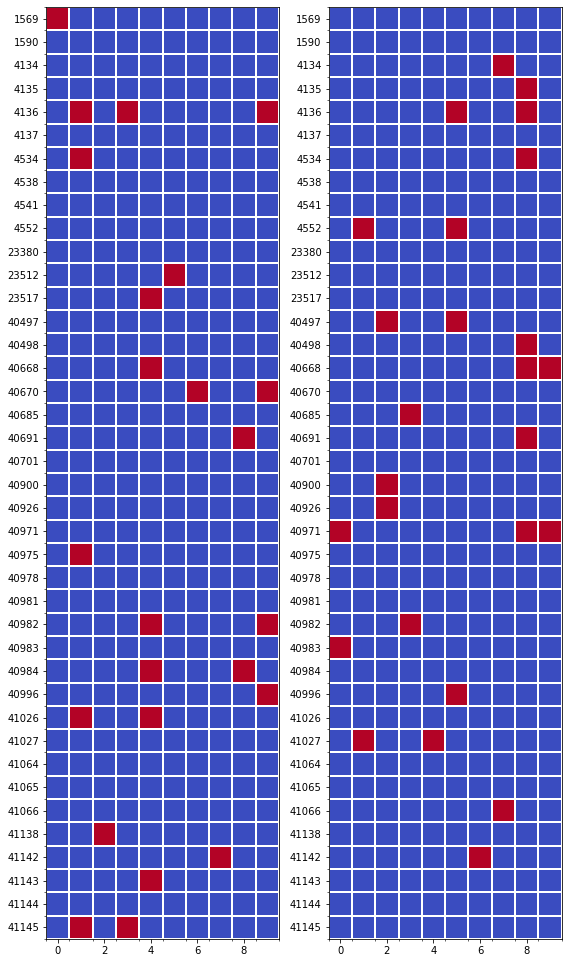

Getting rows of 360 indices: {2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209

  0%|          | 0/18 [00:00<?, ?it/s]

error, skipping on 41146
error, skipping on 41146
error, skipping on 41150
error, skipping on 41158
error, skipping on 41158
error, skipping on 41158
error, skipping on 41159
error, skipping on 41159
error, skipping on 41161
error, skipping on 41161
error, skipping on 41162
error, skipping on 41162
error, skipping on 41163
error, skipping on 41163
error, skipping on 41164
error, skipping on 41165
error, skipping on 41166
error, skipping on 41167
error, skipping on 41167
error, skipping on 41167
error, skipping on 41168
error, skipping on 41168
error, skipping on 41168
error, skipping on 41168
error, skipping on 41169
error, skipping on 41169
error, skipping on 41946
error, skipping on 42733
error, skipping on 42733
error, skipping on 42734


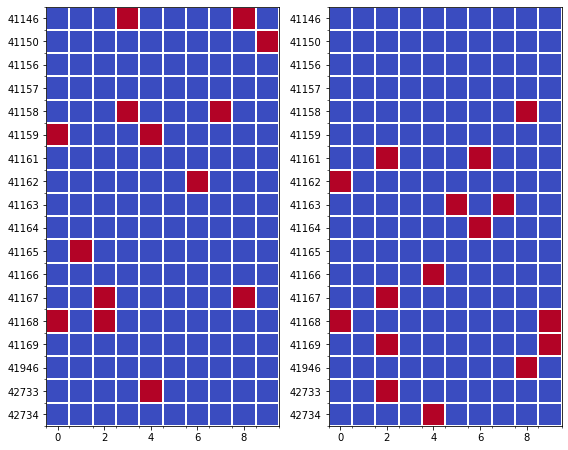

In [4]:
df = process_all_sensitivity_results_from_file("results_classification_sensitivity.csv", chunksize = 40)

In [67]:
pd.unique(df["target_type"])

array(['oob'], dtype=object)

Found data for 60 datasets. For 59 of them, no CSV file exists. Now creating sensitivity analysis results for these.
Getting rows of 800 indices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200

  0%|          | 0/40 [00:00<?, ?it/s]

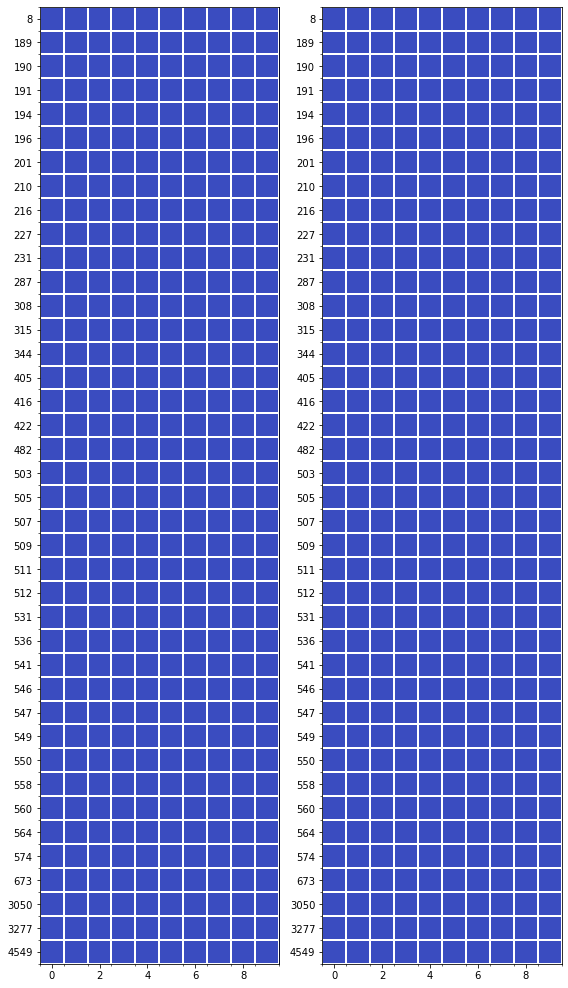

Getting rows of 380 indices: {410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 1010, 1011, 1012, 10

  0%|          | 0/19 [00:00<?, ?it/s]

error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42705
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728
error, skipping on 42728


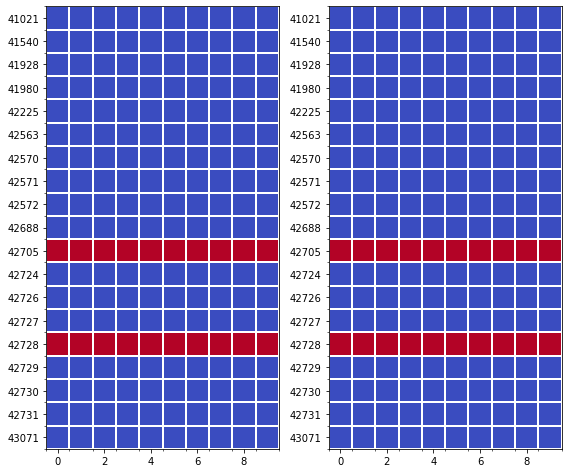

In [4]:
process_all_sensitivity_results_from_file("results_regression_sensitivity.csv", chunksize = 40)

In [7]:
import pandas as pd
pd.read_csv("sensitivity/21_summary.csv")

,openmlid,target_type,epsilon,w_min,delta,c,bootstrap_repeats,num_trees,reasoning_time_per_tree_in_ns,score_oob,score_val,gap_oob,gap_val,time_train,time_pred,time_score
0,21,oob,0.001,2,2,1,0,40.444444,27.333333,0.276611,0.169444,1.152667e-01,0.011678,4.137736e+04,1.005803e+04,1473.644444
1,21,oob,0.001,2,2,1,2,40.444444,45.333333,0.276611,0.169444,1.152667e-01,0.011678,4.137736e+04,1.005803e+04,1473.644444
2,21,oob,0.001,2,2,1,5,40.444444,49.777778,0.276611,0.169444,1.152667e-01,0.011678,4.137736e+04,1.005803e+04,1473.644444
3,21,oob,0.001,2,2,1,10,40.444444,56.444444,0.276611,0.169444,1.152667e-01,0.011678,4.137736e+04,1.005803e+04,1473.644444
4,21,oob,0.001,2,2,1,20,40.444444,69.777778,0.276611,0.169444,1.152667e-01,0.011678,4.137736e+04,1.005803e+04,1473.644444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139855,21,val,0.100,10000,10000,1000000,0,9362.500000,2.125000,0.165513,0.146625,-6.938894e-18,0.000001,1.294080e+07,3.154948e+06,460967.500000
139856,21,val,0.100,10000,10000,1000000,2,9362.500000,2.125000,0.165513,0.146625,-6.938894e-18,0.000001,1.294080e+07,3.154948e+06,460967.500000
139857,21,val,0.100,10000,10000,1000000,5,9362.500000,2.250000,0.165513,0.146625,-6.938894e-18,0.000001,1.294080e+07,3.154948e+06,460967.500000
139858,21,val,0.100,10000,10000,1000000,10,9362.500000,2.375000,0.165513,0.146625,-6.938894e-18,0.000001,1.294080e+07,3.154948e+06,460967.500000
